# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3013460817640408543
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4181524480
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6803007977870625946
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
#%load_ext autoreload
#%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

In [3]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='custom')

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files


0it [00:00, ?it/s]

Converting training set WAVs to numpy files



0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [4]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
65810
24


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [5]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

243

In [6]:
audios, classes = valGen.__getitem__(5)
classes

array([15,  5,  8, 14,  8, 21,  7, 17,  2, 10,  8,  1, 16,  6,  2, 21, 17,
        2, 18, 20,  6,  9, 15, 13,  8,  6,  5, 17,  4, 22,  8,  9])

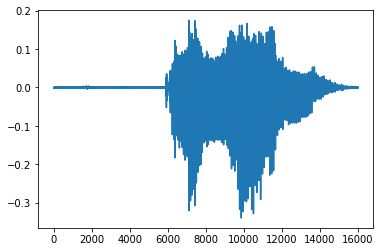

In [7]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [8]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mel_stft (Melspectrogram)   (None, 80, 125, 1)        1091664   
                                                                 
 normalization2d (Normalizat  (None, 80, 125, 1)       0         
 ion2D)                                                          
                                                                 
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [9]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

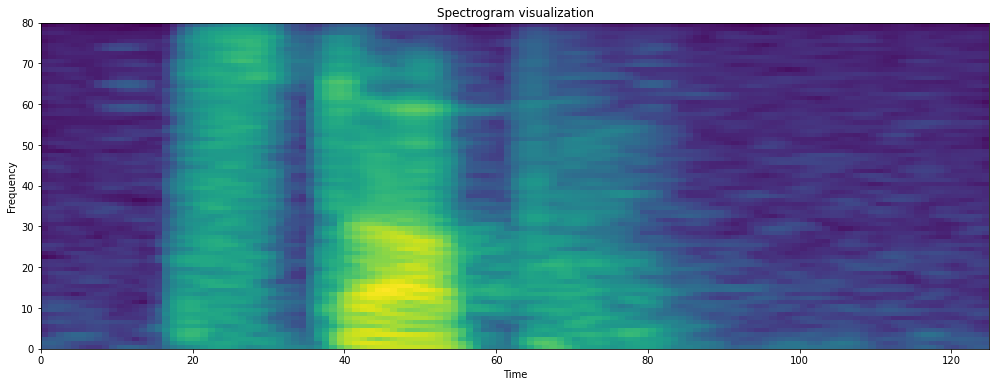

In [10]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [11]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

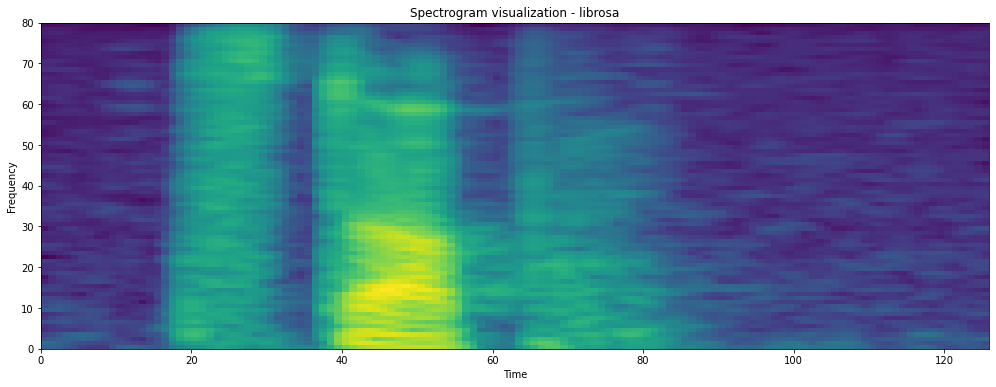

In [12]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [13]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [14]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [15]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, None)      0           ['input[0][0]']                  
                                                                                                  
 mel_stft (Melspectrogram)      (None, 80, None, 1)  1091664     ['reshape[0][0]']                
                                                                                                  
 mel_stft_norm (Normalization2D  (None, 80, None, 1)  0          ['mel_stft[0][0]']               
 )                                                                                            

In [16]:
# model.load_weights('model-attRNN.h5')

In [17]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [18]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN-custom_word.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=100, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])


Changing learning rate to 0.001
Epoch 1/100

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.86343, saving model to model-attRNN-custom_word.h5
2056/2056 - 101s - loss: 0.8074 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.4533 - val_sparse_categorical_accuracy: 0.8634 - lr: 0.0010 - 101s/epoch - 49ms/step
Changing learning rate to 0.001
Epoch 2/100

Epoch 00002: val_sparse_categorical_accuracy improved from 0.86343 to 0.92978, saving model to model-attRNN-custom_word.h5
2056/2056 - 92s - loss: 0.2721 - sparse_categorical_accuracy: 0.9158 - val_loss: 0.2301 - val_sparse_categorical_accuracy: 0.9298 - lr: 0.0010 - 92s/epoch - 45ms/step
Changing learning rate to 0.001
Epoch 3/100

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.92978
2056/2056 - 93s - loss: 0.1961 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.2277 - val_sparse_categorical_accuracy: 0.9295 - lr: 0.0010 - 93s/epoch - 45ms/step
Changing learning rate to 0.001
Epoch 4/100



In [19]:
model.save('model-attRNN-custom_word.h5')

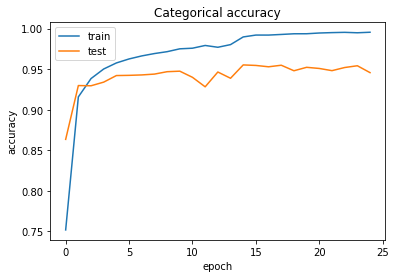

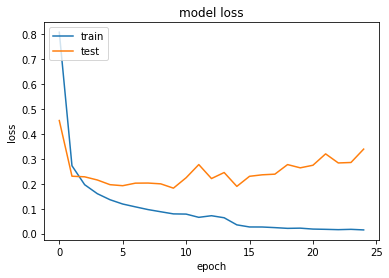

In [20]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# results.history

In [22]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

In [23]:
# load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN-custom_word.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
#model.load_weights('model-attRNN.h5')

In [24]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [25]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.026131467893719673, 0.9925978779792786] 
Validation: [0.19125361740589142, 0.9552469253540039] 
Test: [0.1913890391588211, 0.9587224721908569]


In [26]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [27]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [28]:
audios, classes = valGen.__getitem__(3)
classes

array([ 9,  5,  2, 15, 19, 19,  1, 15,  3, 17,  1,  4,  6, 14, 12, 20,  7,
        7,  7, 23, 17,  1, 16,  4, 18, 19, 12,  2, 15,  4, 22,  9])

In [29]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

3

In [30]:
outs, attW, specs = attSpeechModel.predict(audios)

In [31]:
np.argmax(outs,axis=1)

array([ 9,  5,  2, 15, 19, 19,  1, 15,  3, 17,  1,  4,  6, 14, 12, 20,  7,
        7,  7, 23, 17,  1, 16,  4, 18, 19, 12,  2, 15,  9, 22,  9],
      dtype=int64)

In [32]:
specs.shape

(32, 80, 125, 1)

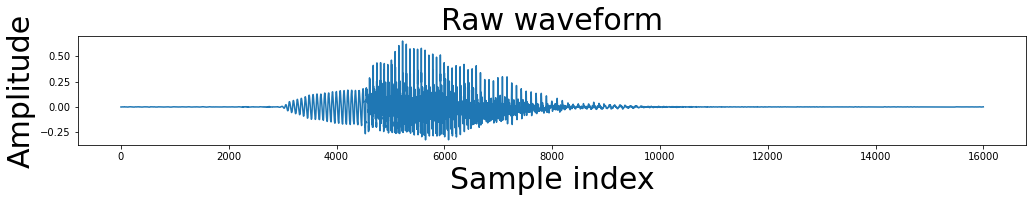

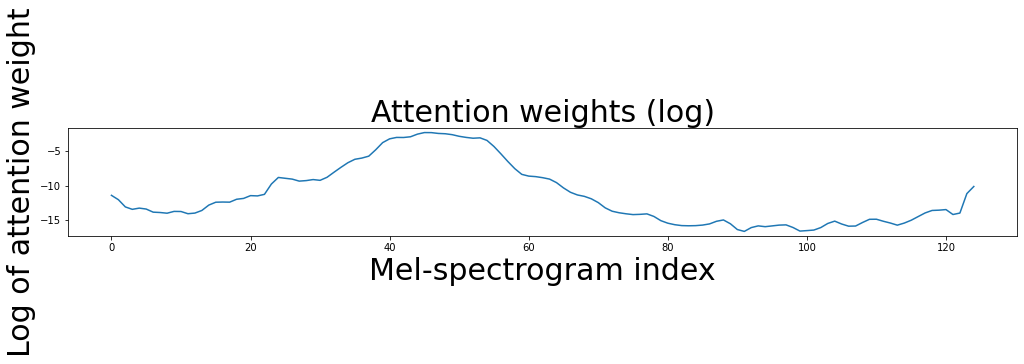

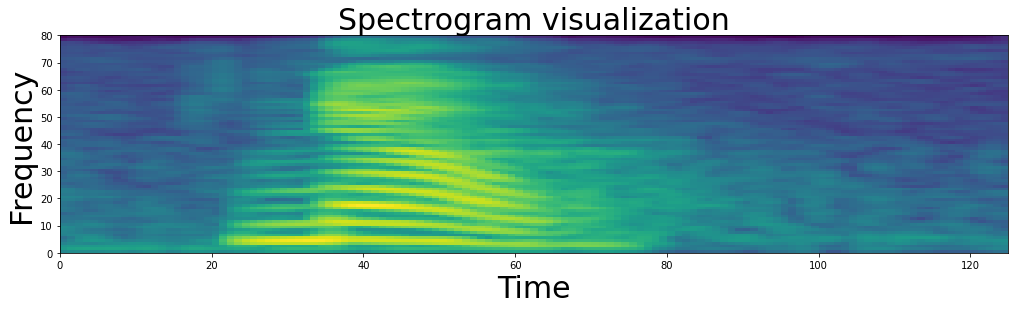

In [33]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [34]:
x_test[0]

array([ 3.05175781e-05,  3.05175781e-05,  1.52587891e-04, ...,
       -7.32421875e-04, -4.48608398e-03,  4.63867188e-03])

In [35]:
y_pred = model.predict(x_test, verbose=1)

272/272 [==============================] - 7s 20ms/step


In [36]:
print(np.argmax(y_pred,1))

[ 7  7  7 ... 10 16 16]


In [37]:
print(len(np.argmax(y_pred,1)))

8673


In [38]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [39]:
#set(y_test)

In [40]:

#classes=["yes","no","up","down","left","right","on","off","stop","go","backward","forward"]

In [41]:
#35word, v2
# classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#            'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
#            'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
#            'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
#            'visual', 'wow']

In [42]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
#         'marvin', 'sheila', 'tree', 'wow']

In [43]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

In [47]:
#custom, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'follow', 'forward']

Confusion matrix, without normalization


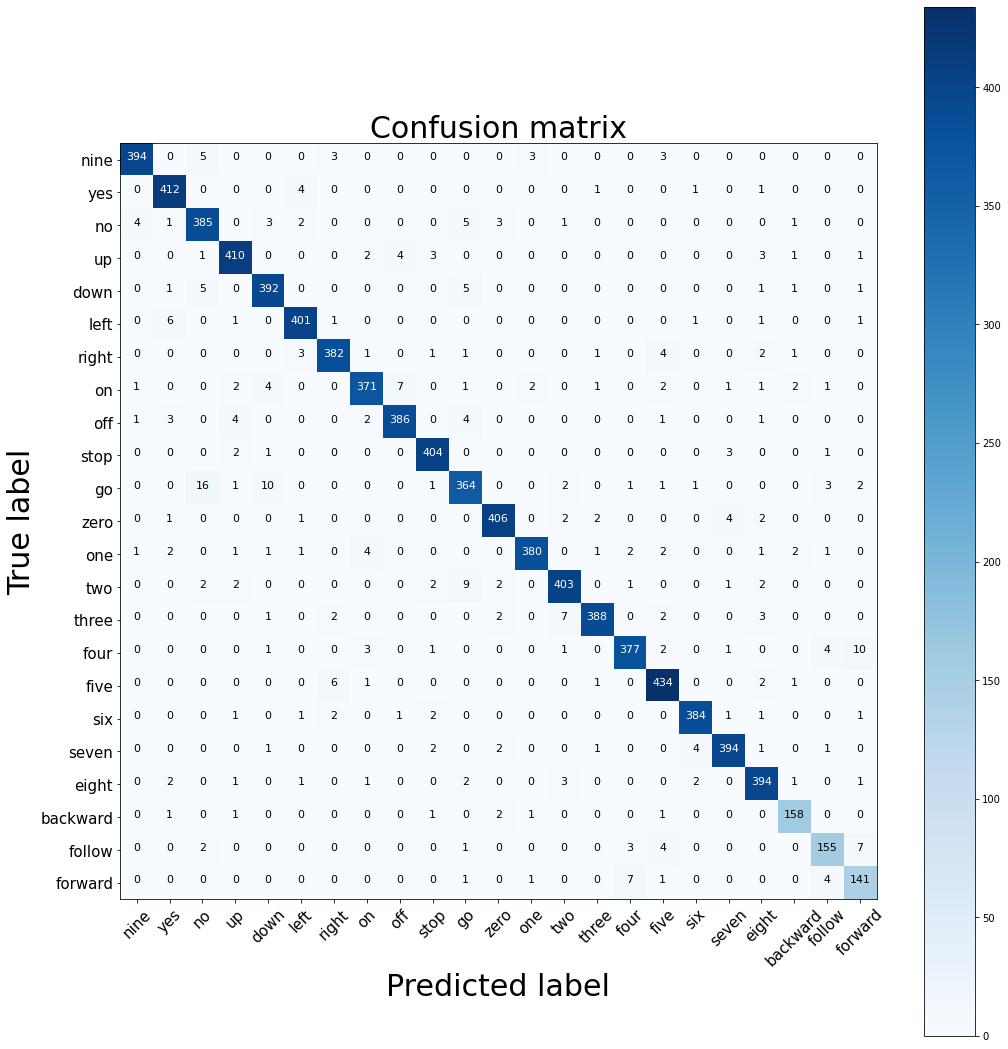

In [48]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [46]:
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.7.0', '0.2.0', '1.4.0', '0.8.1']